# Experimental data

In [1]:
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from cosmos.models import Tracker
from pyro import param

In [2]:
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)


In [3]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, \
                            precision_score, recall_score, \
                            roc_curve

from scipy.io import loadmat

## Orange dye non-attenuated data

Tracker v1.1.3flat

In [4]:
results = {}
predictions = {}
true_labels = {}
snr = []

names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]

for name in names:
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.4three/S1/K2/nocontrol/lr0.005/bs10")
    results[name] = pd.read_csv(
        os.path.join(path_params, "params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_params, "predictions.npy"))
    true_labels[name] = np.load(os.path.join(path_data, "labels.npy"))
    
    #model = Tracker(S=1)
    #model.load(path_data, False, "cpu")
    #model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

In [5]:
df = pd.DataFrame(data=results).T.drop(columns=[float("nan"), "pi_z_0", "pi_j_0", "width_mode_0", "width_size_0"])
#df["SNR"] = snr
df

,iter,-ELBO,proximity_0,gain,pi_z_1,pi_j_1,MCC,Recall,Precision,FN,TP,TN,FP
FL_5555_6684_1p3OD,29900.0,41269324.0,0.5,6.711177,0.032725,0.047983,0.917775,0.896266,0.943231,75.0,648.0,33739.0,39.0
FL_4445_5554_1p1OD,29900.0,30353458.0,0.5,6.794966,0.092208,0.035948,0.961307,0.959115,0.968200,61.0,1431.0,23005.0,47.0
FL_3339_4444_0p8OD,29900.0,36871724.0,0.5,6.654676,0.063283,0.026183,0.914734,0.970052,0.867288,23.0,745.0,26365.0,114.0
FL_2226_3338_0p6OD,29900.0,44531692.0,0.5,6.955616,0.112673,0.095902,0.778239,0.957091,0.657870,95.0,2119.0,32897.0,1102.0
FL_1118_2225_0p3OD,29900.0,45142968.0,0.5,6.566244,0.038679,0.047670,0.801392,0.925620,0.701461,54.0,672.0,35208.0,286.0
FL_1_1117_0OD,20100.0,49881520.0,0.5,6.932622,0.036814,0.091016,0.758377,0.919540,0.633803,63.0,720.0,41483.0,416.0


In [54]:
# load cosmos results
name = "FL_2226_3338_0p6OD"
path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
path_params = os.path.join(path_data, "runs/tracker/v1.1.4three/S1/K3/nocontrol/lr0.005/bs5")
model = Tracker(S=1, K=3)
model.load(path_data, False, "cpu")
model.load_parameters(path_params)

torch.Size([578, 14, 14])


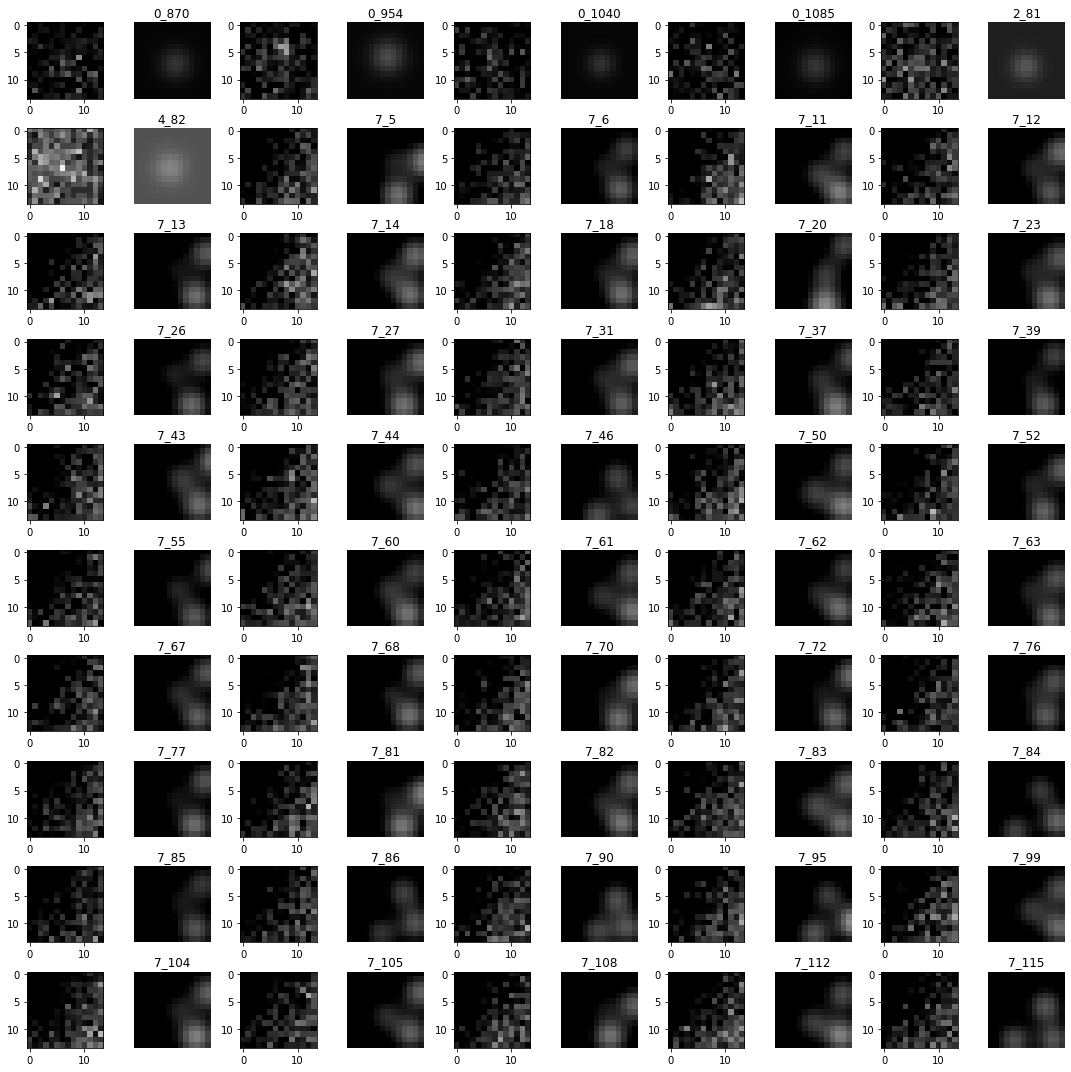

In [55]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(50, len(result))):
    plt.subplot(10, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[i], f[i]] * (model.m_probs[:, n[i], f[i], 1] > 0.5),
    param("d/w_mode").data[:, n[i], f[i]],
    param("d/x_mode").data[:, n[i], f[i]],
    param("d/y_mode").data[:, n[i], f[i]],
    n[i], f[i]).sum(0)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    
    plt.subplot(10, 10, 2*i+2)
    plt.title(f"{n[i]}_{f[i]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

torch.Size([1102, 14, 14])


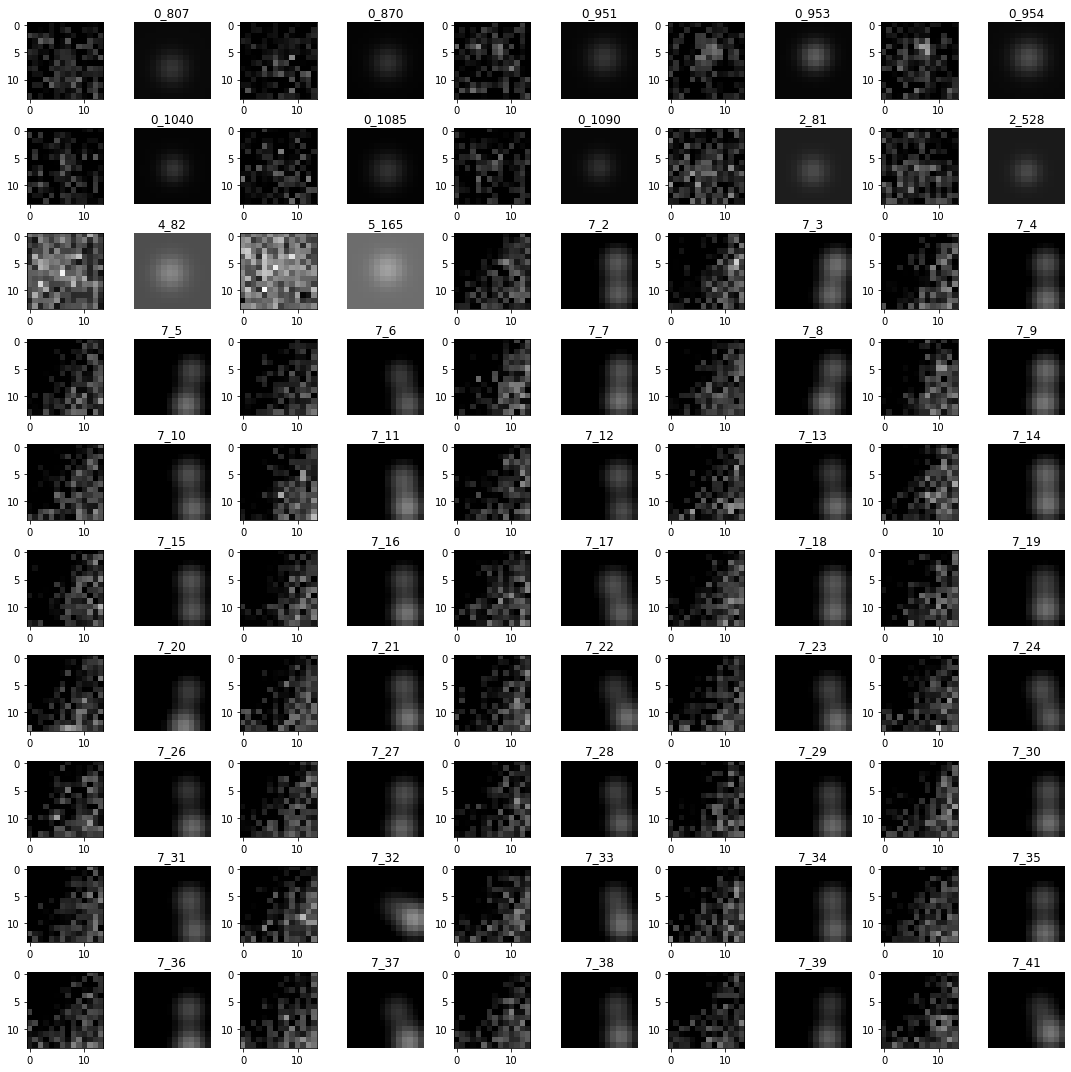

In [42]:
# spots missed by cosmos
mask = (((model.data.labels["z"] == 0) & (model.z_marginal.numpy() > 0.5)))

n, f = np.nonzero(mask)

result = model.data.data[mask.astype("bool"), :, :]
print(result.shape)

plt.figure(figsize=(15,15))
for i in range(min(50, len(result))):
    plt.subplot(10, 10, 2*i+1)
    gaussians = model.data_loc(
    param("d/h_loc").data[:, n[i], f[i]] * (model.m_probs[:, n[i], f[i], 1] > 0.5),
    param("d/w_mode").data[:, n[i], f[i]],
    param("d/x_mode").data[:, n[i], f[i]],
    param("d/y_mode").data[:, n[i], f[i]],
    n[i], f[i]).sum(0)
    ideal = model.offset_mean + param("d/b_loc").data[n[i], f[i]] + gaussians
    plt.imshow(result[i].numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    
    plt.subplot(10, 10, 2*i+2)
    plt.title(f"{n[i]}_{f[i]}")
    plt.imshow(ideal.numpy(), vmin=model.data.vmin, vmax=model.data.vmax, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [21]:
df = pd.DataFrame(data=results).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
df["SNR"] = snr
df

,iter,-ELBO,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP,SNR
FL_5555_6684_1p3OD,29900.0,40515940.0,6.852407,0.038298,0.031055,0.915697,0.905947,0.929078,68.0,655.0,33728.0,50.0,1.688353
FL_4445_5554_1p1OD,29900.0,30591322.0,6.725662,0.101534,0.023240,0.964020,0.967828,0.964596,48.0,1444.0,22999.0,53.0,1.630696
FL_3339_4444_0p8OD,29900.0,36886452.0,6.634371,0.074356,0.015539,0.895820,0.975260,0.828540,19.0,749.0,26324.0,155.0,1.269961
FL_2226_3338_0p6OD,29900.0,43654948.0,6.926970,0.098242,0.075726,0.961233,0.962511,0.964690,83.0,2131.0,33921.0,78.0,1.607510
FL_1118_2225_0p3OD,29900.0,45101560.0,6.566349,0.031429,0.038498,0.927009,0.929752,0.927198,51.0,675.0,35441.0,53.0,1.473022
FL_1_1117_0OD,29900.0,49636644.0,6.729361,0.030443,0.090154,0.899000,0.878672,0.923490,95.0,688.0,41842.0,57.0,1.449292


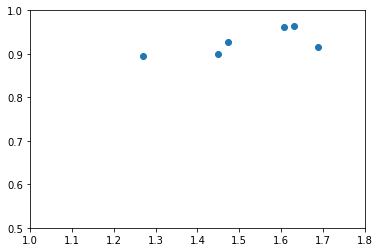

In [27]:
plt.plot(df["SNR"], df["MCC"], "o")
plt.xlim(1,1.8)
plt.ylim(0.5,1)
plt.show()

## Orange dye attenuated data

In [34]:
snr = np.array([0.63, 0.79, 1.12, 1.41, 1.99, 2.81]) * 1.6 / 2.81

Tracker v1.1.3

In [15]:
results = {}
predictions = {}
true_labels = {}
snr = []

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

for name in names:
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    results[name] = pd.read_csv(
        os.path.join(path_params, "params_last.csv"),
        header=None, squeeze=True, index_col=0)
    predictions[name] = np.load(
        os.path.join(path_params, "predictions.npy"))
    true_labels[name] = np.load(os.path.join(path_data, "labels.npy"))
    
    # model = Tracker(S=1)
    # model.load(path_data, False, "cpu")
    # model.load_parameters(path_params)
    # snr.append(float(model.snr().mean()))

In [16]:
scores_v1p13 = pd.DataFrame(data=results).T.drop(columns=[float("nan"), "pi_0", "lamda_0", "width_mode_0", "width_size_0"])
#scores_v1p13["SNR"] = snr
scores_v1p13

,iter,-ELBO,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,29900.0,27305760.0,1.769059,0.003534,0.026631,0.389858,0.163389,0.947368,553.0,108.0,33744.0,6.0
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,29900.0,20433688.0,2.877008,0.014074,0.027418,0.502883,0.266805,0.992268,1058.0,385.0,23013.0,3.0
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,29900.0,25251286.0,5.252812,0.023329,0.002412,0.721728,0.591700,0.894737,305.0,442.0,26305.0,52.0
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,29900.0,31451082.0,6.725665,0.073904,0.008817,0.927197,0.890618,0.973711,232.0,1889.0,33878.0,51.0
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,29900.0,36758332.0,6.801042,0.042468,0.017617,0.941185,0.974702,0.910987,17.0,655.0,35391.0,64.0
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,29900.0,44042968.0,6.901953,0.040881,0.093299,0.880256,0.980422,0.793902,13.0,651.0,41700.0,169.0


In [36]:
scores_sp = pd.DataFrame(data={"spMCC": [matthews_corrcoef(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                   "spRecall": [recall_score(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                   "spPrecision": [precision_score(true_labels[name]["z"][true_labels[name]["z"]<2], true_labels[name]["spotpicker"][true_labels[name]["z"]<2]) for name in names],
                    },
             index=names)
scores_sp

,spMCC,spRecall,spPrecision
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,0.426138,0.211800,0.875000
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,0.480272,0.244629,0.988796
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,0.674511,0.514056,0.901408
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,0.893359,0.857614,0.942976
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,0.910230,0.962798,0.863818
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,0.840818,0.980422,0.725753


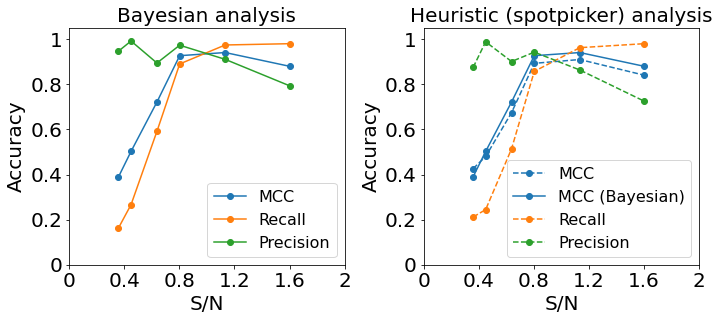

In [40]:
plt.figure(figsize=(10,8))

plt.subplot(221)
plt.plot(snr, scores_v1p13["MCC"], "o-", label="MCC")
plt.plot(snr, scores_v1p13["Recall"], "o-", label="Recall")
plt.plot(snr, scores_v1p13["Precision"], "o-", label="Precision")

plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"S/N", fontsize=20)
plt.ylabel(r"Accuracy", fontsize=20)
plt.title(r"Bayesian analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=16)

plt.subplot(222)
plt.plot(snr, scores_sp["spMCC"], "o--", label="MCC")
plt.plot(snr, scores_v1p13["MCC"], "o-", color="C0", label="MCC (Bayesian)")
plt.plot(snr, scores_sp["spRecall"], "o--", label="Recall")
plt.plot(snr, scores_sp["spPrecision"], "o--", label="Precision")
plt.ylim(0,1.05)
plt.xlim(0,1)
plt.xlabel(r"S/N", fontsize=20)
plt.ylabel(r"Accuracy", fontsize=20)
plt.title(r"Heuristic (spotpicker) analysis", fontsize=20)

plt.gca().axes.get_xaxis().set_ticks(np.arange(6)*0.4)
plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=20)
plt.yticks(size=20)
plt.legend(fontsize=16)


plt.tight_layout()
plt.show()

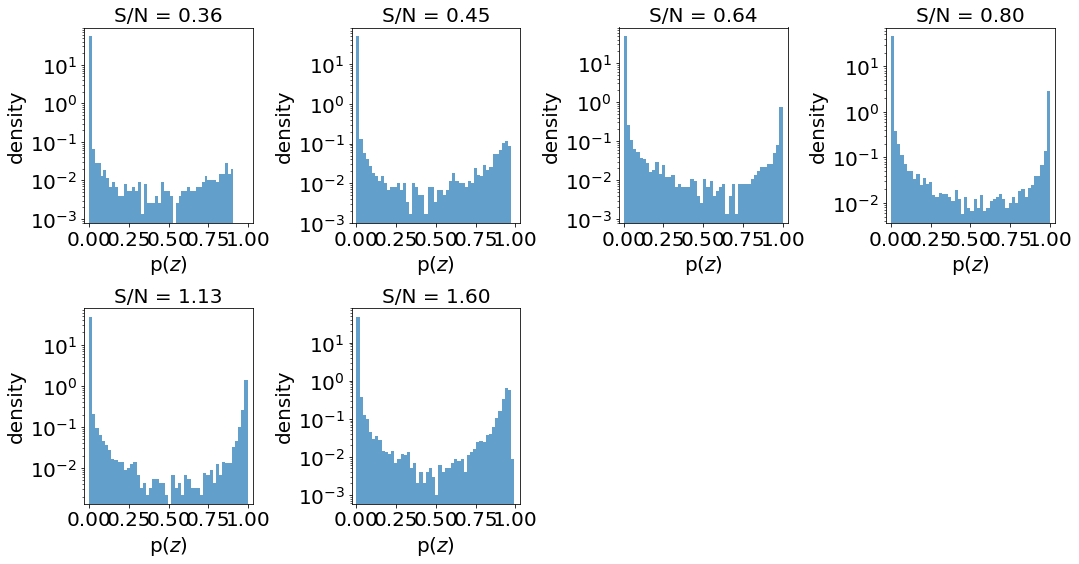

In [43]:
plt.figure(figsize=(15,15))
for i, name in enumerate(names):
    plt.subplot(4, 4, i+1)
    plt.hist(predictions[name]["z_prob"].ravel(), bins=50, density=True, alpha=0.7)
    plt.xlim(-0.03, 1.03)
    #plt.ylim(0, 10)
    plt.yscale('log', nonpositive='clip')
    #plt.gca().axes.get_xaxis().set_ticks([0.8, 0.9, 1])
    #plt.gca().axes.get_yaxis().set_ticks(np.arange(6)*0.2)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel(r"p($z$)", fontsize=20)
    plt.ylabel(r"density", fontsize=20)
    plt.title(r"S/N = {:.2f}".format(snr[i]), fontsize=20)

plt.tight_layout()
plt.show()

In [78]:
model.offset_var.item()

11.3193359375

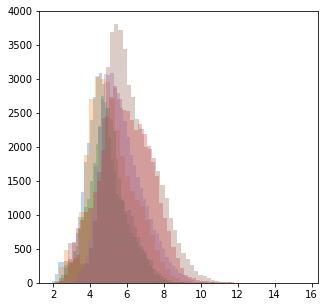

In [83]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    #pyro.get_param_store().load(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
    #    map_location=torch.device("cpu"))
    model = Tracker(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    


    #plt.hist(param("d/h_loc").data[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist(param("d/b_loc").data.flatten().numpy()/param("d/b_beta").data.flatten().numpy(), bins=50, alpha=0.3)
    #plt.hist(np.sqrt(param("d/b_loc").data.flatten().numpy() * param("gain").item() + model.offset_var.item())/14, bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 15:30][mask[:, 15:30]].numpy(), bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 30:45][mask[:, 30:45]].numpy(), bins=50, alpha=0.3)
    #plt.xlim(0, 10000)
plt.show()

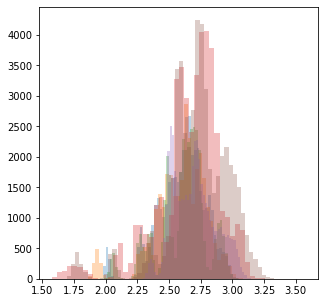

In [84]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, i+1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    #pyro.get_param_store().load(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
    #    map_location=torch.device("cpu"))
    model = Tracker(S=1, K=2)
    model.load(path_data, False, "cpu")
    model.load_parameters(path_params)
    #snr.append(float(model.snr().mean()))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    


    #plt.hist(param("d/h_loc").data[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.hist(param("d/b_loc").data.flatten().numpy()/param("d/b_beta").data.flatten().numpy(), bins=50, alpha=0.3)
    plt.hist(np.sqrt(param("d/b_loc").data.flatten().numpy() * param("gain").item() + model.offset_var.item())/14, bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 15:30][mask[:, 15:30]].numpy(), bins=50, alpha=0.3)
    #plt.hist(param("d/h_loc").data[:, 30:45][mask[:, 30:45]].numpy(), bins=50, alpha=0.3)
    #plt.xlim(0, 10000)
plt.show()

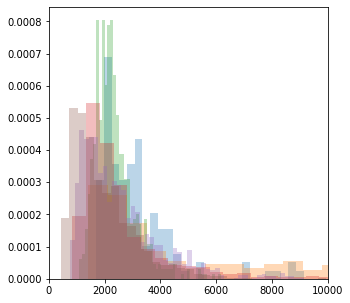

In [67]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    #plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist((param("d/h_loc").data / scores_v1p13.loc[name, "atten"])[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.xlim(0, 10000)
plt.show()

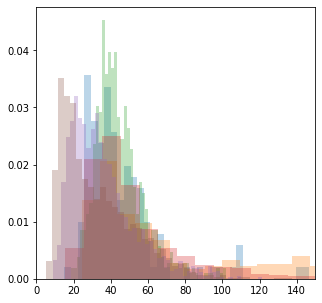

In [70]:
# path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
# path_params = os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10")

names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.hist((param("d/h_loc").data / scores_v1p13.loc[name, "atten"])[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.xlim(0, 150)
plt.show()

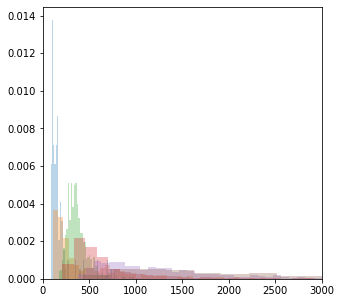

In [63]:
names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    #plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist((param("d/h_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.xlim(0, 3000)
    
x = torch.arange(0,10000.,1)
d1 = dist.Gamma(2190 * 0.0012, 0.0012)
#plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
plt.show()

In [47]:
(param("d/h_loc").data)[mask].mean() / (param("d/h_loc").data)[mask].var()

tensor(0.0012)

In [48]:
(param("d/h_loc").data)[mask].mean()

tensor(2190.9536)

tensor(192.5957, grad_fn=<MeanBackward0>)
tensor(11.8157, grad_fn=<MeanBackward0>)
tensor(195.3535, grad_fn=<MeanBackward0>)
tensor(9.1347, grad_fn=<MeanBackward0>)
tensor(200.2661, grad_fn=<MeanBackward0>)
tensor(11.0746, grad_fn=<MeanBackward0>)
tensor(199.2983, grad_fn=<MeanBackward0>)
tensor(6.2144, grad_fn=<MeanBackward0>)
tensor(215.4230, grad_fn=<MeanBackward0>)
tensor(8.2129, grad_fn=<MeanBackward0>)
tensor(215.7860, grad_fn=<MeanBackward0>)
tensor(7.0940, grad_fn=<MeanBackward0>)


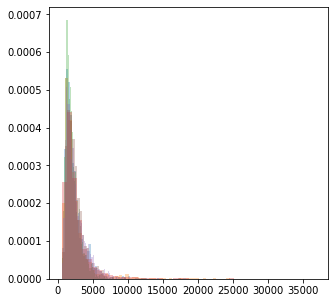

In [87]:
names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)
    print(param("d/background_loc").mean())
    print(param("d/background_beta").mean())
    #plt.hist((param("d/h_loc").data / param("d/b_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    plt.hist((param("d/h_loc").data)[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.xlim(0, 50)
#x = torch.arange(0,20000.,1)
#d1 = dist.HalfNormal(10000.)
#plt.plot(x, torch.exp(d1.log_prob(x)).cpu(), lw=5)
plt.show()

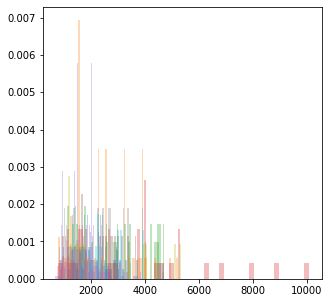

In [13]:
#names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
#         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]
names = ["FL_5555_6684_1p3OD"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))
    for j in range(15):
        mask = param("d/theta_probs").data[j, :, 1:] > 0.5
        mask = mask.permute(1, 0)

        plt.hist((param("d/h_loc").data[:, j])[mask].numpy(), bins=50, density=True, alpha=0.3)
    #plt.xlim(0, 50)
plt.show()

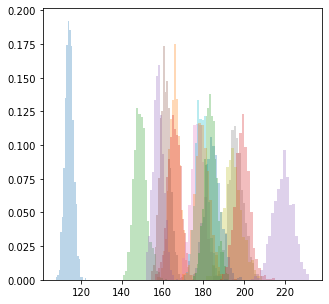

In [10]:
#names = ["FL_5555_6684_1p3OD", "FL_4445_5554_1p1OD", "FL_3339_4444_0p8OD",
#         "FL_2226_3338_0p6OD", "FL_1118_2225_0p3OD", "FL_1_1117_0OD"]
names = ["FL_5555_6684_1p3OD"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/nonattenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    for j in range(15):
        plt.hist(param("d/b_loc").data[j,:].numpy(), bins=20, density=True, alpha=0.3)
    #plt.xlim(0, 50)
plt.show()

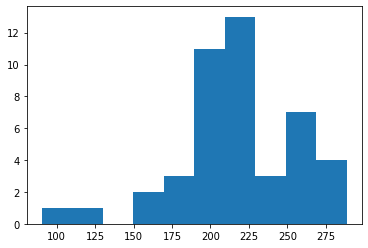

In [11]:
plt.hist(param("d/background_loc").data.numpy())
plt.show()

In [9]:
param("d/background_loc").std()

tensor(38.6722, grad_fn=<StdBackward0>)

In [6]:
param("d/b_loc").data.shape

torch.Size([45, 1117])

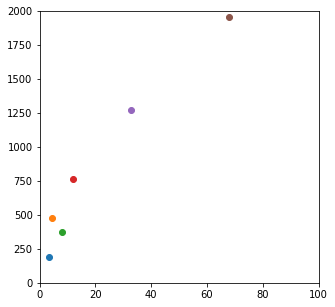

In [25]:
names = ["FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob", "FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob",
         "FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob", "FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob",
         "FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob", "FL_1_1117_0OD_atten_noHysteresis_0p5_prob"]

plt.figure(figsize=(5,5))
for i, name in enumerate(names):
    #plt.subplot(4, 4, 1)
    pyro.get_param_store().clear()
    path_data = "/shared/centaur/data/experimental/attenuated/{}".format(name)
    #params_last[name] = pd.read_csv(
    #    os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params_last.csv"),
    #    header=None, squeeze=True, index_col=0)
    pyro.get_param_store().load(
        os.path.join(path_data, "runs/tracker/v1.1.3flat/S1/nocontrol/lr0.005/bs10/params"),
        map_location=torch.device("cpu"))

    mask = param("d/theta_probs").data[..., 1:] > 0.5
    mask = mask.permute(2, 0, 1)

    #plt.hist(param("d/b_loc").data.flatten().numpy(), bins=50, density=True, alpha=0.3)
    plt.scatter(param("d/b_loc").data.mean(), param("d/h_loc").data[mask].mean())
    #plt.hist(param("d/b_loc").data.flatten().numpy() / scores_v1p13.loc[name, "atten"], bins=50, density=True, alpha=0.3)
    plt.xlim(0, 100)
    plt.ylim(0, 2000)
plt.show()

In [18]:
scores_v1p13["atten"] = 1/np.power(10, np.array([1.3, 1.1, 0.8, 0.6, 0.3, 0]))
scores_v1p13

,iter,-ELBO,gain,pi_1,lamda_1,MCC,Recall,Precision,FN,TP,TN,FP,atten
FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob,29900.0,27305760.0,1.769059,0.003534,0.026631,0.389858,0.163389,0.947368,553.0,108.0,33744.0,6.0,0.050119
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob,29900.0,20433688.0,2.877008,0.014074,0.027418,0.502883,0.266805,0.992268,1058.0,385.0,23013.0,3.0,0.079433
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob,29900.0,25251286.0,5.252812,0.023329,0.002412,0.721728,0.591700,0.894737,305.0,442.0,26305.0,52.0,0.158489
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob,29900.0,31451082.0,6.725665,0.073904,0.008817,0.927197,0.890618,0.973711,232.0,1889.0,33878.0,51.0,0.251189
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob,29900.0,36758332.0,6.801042,0.042468,0.017617,0.941185,0.974702,0.910987,17.0,655.0,35391.0,64.0,0.501187
FL_1_1117_0OD_atten_noHysteresis_0p5_prob,29900.0,44042968.0,6.901953,0.040881,0.093299,0.880256,0.980422,0.793902,13.0,651.0,41700.0,169.0,1.000000


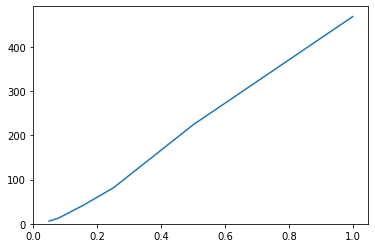

In [65]:
plt.plot(1/np.power(10, np.array([1.3, 1.1, 0.8, 0.6, 0.3, 0])),
         np.array([3.39, 4.45, 8.1, 12.1, 33, 68]) * scores_v1p13["gain"])
plt.xlim(0,)
plt.ylim(0,)
plt.show()

In [59]:
np.array([3.39, 4.45, 8.1, 12.1, 33, 68]) * scores_v1p13["gain"]

FL_5555_6684_1p3OD_atten_noHysteresis_0p5_prob      5.997110
FL_4445_5554_1p1OD_atten_noHysteresis_0p5_prob     12.802684
FL_3339_4444_0p8OD_atten_noHysteresis_0p5_prob     42.547780
FL_2226_3338_0p6OD_atten_noHysteresis_0p5_prob     81.380548
FL_1118_2225_0p3OD_atten_noHysteresis_0p5_prob    224.434389
FL_1_1117_0OD_atten_noHysteresis_0p5_prob         469.332787
Name: gain, dtype: float64